## DPGCE Premium

### Objective
This notebook is designed for running TPCH and TPCDS benchmarks on DPGCE Premium cluster.

### Initialize Public GCS Bucket
This initializes the public GCS bucket from which datasets and utilities will be copied to your GCS bucket.

In [1]:
SOURCE_PUBLIC_GCS_BUCKET = "tpc-benchmarking-kit-bucket"

### Benchmark Configuration Setup

This step initializes the benchmark configurations. These configurations define the parameters for the benchmark run, such as:

- **Benchmark:** The benchmarks to run (e.g., "tpch",  "tpcds",  "tpch,tpcds",  "tpcds,tpch").
- **TPCH Queries to Run:** The specific queries to run for TPCH (e.g., "q1,q2", "q3", "all").
- **TPCDS Queries to Run:** The specific queries to run for TPCDS (e.g., "q1,q2", "q3", "all").
- **Size:** The scale factor or data size (e.g., "sf1000", "sf10000").
- **File Format:** The currently supported file format is Parquet.

**NOTE: You can customize the benchmark_configs to adjust the benchmark settings. After making changes, restart the kernel and re-run all cells for the modifications to take effect.**

In [2]:
benchmark_configs = {
    "benchmark":"tpch,tpcds", # the benchmark that gets specified first is run first
    "TPCH_queries_to_run": "all", # if benchmark does not contain tpch, this will be ignored
    "TPCDS_queries_to_run": "all", # if benchmark does not contain tpcds, this will be ignored
    "size": "sf1000", # sf1000 for 1000GB, sf10000 for 10000GB
    "file_format": "parquet"
}

In [3]:
benchmark_string = benchmark_configs.get("benchmark", "")
size = benchmark_configs.get("size","")
file_format = benchmark_configs.get("file_format", "")

benchmarks_list = [bench.strip() for bench in benchmark_string.split(',')]

first_benchmark = benchmarks_list[0] if len(benchmarks_list) > 0 else None
second_benchmark = benchmarks_list[1] if len(benchmarks_list) > 1 else None

### Validate Benchmark Configurations

In [4]:
# Check for valid benchmark types

if first_benchmark is None:
    print("Error! Please specify benchmark to be run.")
    print("Valid benchmark types are - \n 1. tpch \n 2. tpcds \n 3. tpch,tpcds \n 4. tpcds,tpch")
    raise SystemExit()
    
if first_benchmark != "tpch" and first_benchmark != "tpcds":
    print(f"Error! Unrecognised benchmark type {first_benchmark}.")
    print("Valid benchmark types are - \n 1. tpch \n 2. tpcds \n 3. tpch,tpcds \n 4. tpcds,tpch")
    raise SystemExit()
    
if second_benchmark is not None and second_benchmark != "tpch" and second_benchmark != "tpcds":
    print(f"Error! Unrecognised benchmark type {second_benchmark}.")
    print("Valid benchmark types are - \n 1. tpch \n 2. tpcds \n 3. tpch,tpcds \n 4. tpcds,tpch")
    raise SystemExit()
    
# Check for valid scale factor
if size is None or size == "" :
    print("Error! Please specify scale factor/size")
    print("Valid size values are - \n 1. sf1000 \n 2. sf10000")
    raise SystemExit()

if size != "sf1000" and size != "sf10000":
    print(f"Error! Unsupported value for size {size}")
    print("Valid size values are - \n 1. sf1000 \n 2. sf10000")
    raise SystemExit()

# Check for valid file formats
if file_format is None or file_format == "":
    print("Error! Please specify file format")
    print("Valid file formats are - \n 1. parquet")
    raise SystemExit()    

if file_format != "parquet" :
    print(f"Error! Unrecognised file format {file_format}")
    print("Valid file formats are - \n 1. parquet")
    raise SystemExit()  

print("Benchmark Configurations")
print(f"First benchmark: {first_benchmark}")
print(f"Second benchmark: {second_benchmark}")
print(f"Scale Factor: {size}")
print(f"File Format: {file_format}")

Benchmark Configurations
First benchmark: tpch
Second benchmark: tpcds
Scale Factor: sf1000
File Format: parquet


### Initialization Setup
This cell defines variables storing your DPGCE cluster, region, and project details.

In [5]:
import os
import re
import subprocess
import requests
import json

CLUSTER_NAME = None 
BUCKET_NAME = None
REGION = None
TIER = "premium"

# Get cluster name
def get_dataproc_cluster_name():
    metadata_url = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/dataproc-cluster-name"
    headers = {"Metadata-Flavor": "Google"}

    try:
        response = requests.get(metadata_url, headers=headers, timeout=5)
        response.raise_for_status()  # Raise an exception for HTTP errors (4xx or 5xx)
        cluster_name = response.text
        return cluster_name
    except requests.exceptions.RequestException as e:
        print(f"Could not retrieve Dataproc cluster name from metadata server: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Retrieves the current region in use
def get_gcloud_region():
    metadata_url = "http://metadata.google.internal/computeMetadata/v1/instance/zone"
    headers = {"Metadata-Flavor": "Google"}

    try:
        response = requests.get(metadata_url, headers=headers, timeout=5)
        response.raise_for_status() 
        zone = response.text.split('/')[-1]
        region = '-'.join(zone.split('-')[:-1])
        return region
    except requests.exceptions.RequestException as e:
        print(f"Could not retrieve region from metadata server: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None        

# Returns name of current project
def get_gcloud_project():
    try:
        command = ["gcloud", "config", "get", "project"]
        process = subprocess.run(command, capture_output=True, text=True, check=True)
        project_name = process.stdout.strip()
        return project_name
    except subprocess.CalledProcessError as e:
        raise ValueError(f"Error getting gcloud project: {e}\nStdout: {e.stdout}\nStderr: {e.stderr}")
    except FileNotFoundError:
        raise ValueError("Error: gcloud command not found. Make sure the Google Cloud CLI is installed and in your system's PATH.")
        
# Returns project number of current project
def get_project_number(project_id: str) -> str:
    try:
        command = [
            "gcloud",
            "projects",
            "describe",
            project_id,
            "--format=value(projectNumber)",
        ]
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        project_number = result.stdout.strip()
        return project_number
    except subprocess.CalledProcessError as e:
        raise ValueError(f"Error executing gcloud command for project ID '{project_id}': {e}\nStderr: {e.stderr}")
    except FileNotFoundError:
        raise ValueError("Error: gcloud CLI not found. Make sure it's installed and in your system's PATH.")

CLUSTER_NAME = get_dataproc_cluster_name()
REGION = get_gcloud_region()
PROJECT = get_gcloud_project()
PROJECT_NUMBER = get_project_number(PROJECT)

print(f"Google Cloud Project: {PROJECT}")
print(f"Project Number: {PROJECT_NUMBER}")
print(f"Cluster: {CLUSTER_NAME}")
print(f"Region: {REGION}")

Google Cloud Project: nishitkamdarargo
Project Number: 279814974066
Cluster: dpgce-benchmarking-premium-2
Region: us-east1


### Initialize your GCS Bucket
To run the benchmarks, a Google Cloud Storage (GCS) bucket is required to store necessary utilities.

The default GCS bucket name is `sparkpoc-bucket-dpgce-standard-PROJECT_NUMBER-REGION`. You can use a different bucket name as needed.

**NOTE - The following cell will attempt to create a storage bucket. If a bucket with this name already exists in the specified region and you own it, you might see a "bucket name taken" message or a confirmation of a previous creation. You can safely ignore these messages if your desired bucket is already created. Otherwise, please choose a unique bucket name and try again.**

In [6]:
BUCKET_NAME = f"sparkpoc-bucket-dpgce-premium-{PROJECT_NUMBER}-{REGION}"
print(f"GCS Bucket Name: {BUCKET_NAME}")

GCS Bucket Name: sparkpoc-bucket-dpgce-premium-279814974066-us-east1


In [7]:
! gcloud storage buckets create gs://{BUCKET_NAME} --uniform-bucket-level-access --location={REGION}

Creating gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/...
ERROR: (gcloud.storage.buckets.create) HTTPError 409: Your previous request to create the named bucket succeeded and you already own it.


### Copy Utilities

Run the following cells to copy the necessary utilities in your GCS bucket.

Duplicate file copy operations will be skipped.

**Troubleshooting: If the copy operation seems to hang at 100% for a significant time, it's likely due to a temporary error. In such cases, restarting the kernel and running all cells from the beginning is recommended.**

In [8]:
source_location = f"gs://{SOURCE_PUBLIC_GCS_BUCKET}/notebook_utils/"
destination_location = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/{TIER}/notebook_utils/"

print("Copying utilities")
print(f"Source GCS location: {source_location}")
print(f"Destination GCS location: {destination_location}")
print("")

# Copy notebook_utils which contains queries
! gcloud transfer jobs monitor \
$( gcloud transfer jobs create \
  --format='value(name)' \
  "{source_location}" "{destination_location}" \
)

Copying utilities
Source GCS location: gs://tpc-benchmarking-kit-bucket/notebook_utils/
Destination GCS location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/notebook_utils/

Polling for latest operation name...done.                                      
Operation name: transferJobs-13513057103545324768-15531723508270377158
Parent job: 13513057103545324768
Start time: 2025-08-06T09:30:38.022291382Z
SUCCESS | 0% (0B of 0B) | Skipped: 162.6kiB | Errors: 0 : 0 /
End time: 2025-08-06T09:30:50.161304571Z


### Copy Datasets

Duplicate file copy operations will be skipped.

**Troubleshooting: If the copy operation seems to hang at 100% for a significant time, it's likely due to a temporary error. In such cases, restarting the kernel and running all cells from the beginning is recommended.**

In [9]:
print(f"Copying {first_benchmark} {size} datasets")

source_location = f"gs://{SOURCE_PUBLIC_GCS_BUCKET}/{first_benchmark}/{size}/"
destination_location = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/{TIER}/{first_benchmark}/{size}/"

print(f"Source GCS location: {source_location}")
print(f"Destination GCS location: {destination_location}")
print("")

# Copy TPC datasets
! gcloud transfer jobs monitor \
$( gcloud transfer jobs create \
  --format='value(name)' \
  "{source_location}" "{destination_location}"\
)

Copying tpch sf1000 datasets
Source GCS location: gs://tpc-benchmarking-kit-bucket/tpch/sf1000/
Destination GCS location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/tpch/sf1000/

Polling for latest operation name...done.                                      
Operation name: transferJobs-15032519642485440616-17756618311735289807
Parent job: 15032519642485440616
Start time: 2025-08-06T09:30:53.341659215Z
SUCCESS | 0% (0B of 0B) | Skipped: 351.5GiB | Errors: 0 : 0 |
End time: 2025-08-06T09:31:04.990007760Z


In [10]:
if second_benchmark is not None:
    print(f"Copying {second_benchmark} {size} datasets")    
    
    source_location = f"gs://{SOURCE_PUBLIC_GCS_BUCKET}/{second_benchmark}/{size}/"
    destination_location = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/{TIER}/{second_benchmark}/{size}/"
    
    print(f"Source GCS location: {source_location}")
    print(f"Destination GCS location: {destination_location}")
    print("")    
    
    # Copy TPC datasets
    ! gcloud transfer jobs monitor \
    $( gcloud transfer jobs create \
      --format='value(name)' \
      "{source_location}" "{destination_location}"\
    )

else:
    print("Second benchmark is empty")
    print("Skipping this step.")

Copying tpcds sf1000 datasets
Source GCS location: gs://tpc-benchmarking-kit-bucket/tpcds/sf1000/
Destination GCS location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/tpcds/sf1000/

Polling for latest operation name...done.                                      
Operation name: transferJobs-17830822403559275155-8911596264472311597
Parent job: 17830822403559275155
Start time: 2025-08-06T09:31:07.126309681Z
SUCCESS | 0% (0B of 0B) | Skipped: 304.3GiB | Errors: 0 : 0 /
End time: 2025-08-06T09:31:19.188658873Z


### Define Benchmark Utility Functions

To facilitate the execution of TPC benchmarks, we need to load a set of utility functions. These functions are defined in the following cell and handle tasks such as:

- Query execution timing
- Data loading and setup
- Result formatting
- Writing results to GCS
- Terminating current Spark session


In [11]:
from pyspark.sql import SparkSession
from urllib.parse import urlparse
from py4j.java_gateway import java_import
import os
from google.cloud import storage
import time
from typing import Callable, List, Tuple
import csv
import io
import matplotlib.pyplot as plt
from prettytable import PrettyTable, HRuleStyle
import subprocess
import re

################################################ Run Benchmark ############################################

# Set up TPCH tables
def setupTPCHTables(spark: SparkSession, locationPath: str, size: str):
    spark.sparkContext.setJobDescription("SETUP")
    tpchtables = ["customer", "lineitem", "nation", "orders", "part", "partsupp", "region", "supplier"]

    print("Setting up TPCH tables")

    ntn = f"""create table nation (n_nationkey long, n_name string, n_regionkey long, n_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/nation/" options ("compression"="snappy")"""
    rgn = f"""create table region (r_regionkey long, r_name string, r_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/region/" options ("compression"="snappy")"""
    prtsupp = f"""create table partsupp (ps_partkey long, ps_suppkey long, ps_availqty int, ps_supplycost decimal(12, 2), ps_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/partsupp/" options ("compression"="snappy")"""
    supp = f"""create table supplier (s_suppkey long, s_name string, s_address string, s_nationkey long, s_phone string, s_acctbal decimal(12, 2), s_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/supplier/" options ("compression"="snappy")"""
    odrs = f"""create table orders (o_orderkey long, o_custkey long, o_orderstatus string, o_totalprice decimal(12, 2), o_orderdate date, o_orderpriority string, o_clerk string, o_shippriority int, o_comment string) using parquet partitioned by (o_orderdate) location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/orders/" options ("compression"="snappy")"""
    cstmr = f"""create table customer (c_custkey long, c_name string, c_address string, c_nationkey long, c_phone string, c_acctbal decimal(12, 2), c_mktsegment string, c_comment string) using parquet partitioned by (c_mktsegment) location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/customer/" options ("compression"="snappy")"""
    prt = f"""create table part (p_partkey long, p_name string, p_mfgr string, p_brand string, p_type string, p_size int, p_container string, p_retailprice decimal(12, 2), p_comment string) using parquet partitioned by (p_brand) location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/part/" options ("compression"="snappy")"""
    litem = f"""create table lineitem (l_orderkey long, l_partkey long, l_suppkey long, l_linenumber int, l_quantity decimal(12, 2), l_extendedprice decimal(12, 2), l_discount decimal(12, 2), l_tax decimal(12,2), l_returnflag string, l_linestatus string, l_shipdate date, l_commitdate date, l_receiptdate date, l_shipinstruct string, l_shipmode string, l_comment string) USING parquet PARTITIONED BY (l_shipdate) LOCATION "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/lineitem/" options ("compression"="snappy")"""

    for table in tpchtables:
        spark.sql(f"DROP TABLE IF EXISTS {table}")

    spark.sql(ntn)
    spark.sql(rgn)
    spark.sql(prtsupp)
    spark.sql(supp)
    spark.sql(odrs)
    spark.sql(cstmr)
    spark.sql(prt)
    spark.sql(litem)
    spark.sql("msck repair table orders")
    spark.sql("msck repair table customer")
    spark.sql("msck repair table part")
    spark.sql("msck repair table lineitem")
    
    print("TPCH Tables set up")

# Set up TPCDS tables
def setupTPCDSTables(spark: SparkSession, locationPath: str, size: str):
    spark.sparkContext.setJobDescription("SETUP")
    tpcdstables = ["call_center", "catalog_page", "catalog_returns", "catalog_sales", "customer", "customer_address", "customer_demographics", "date_dim", "household_demographics", "income_band", "inventory", "item", "promotion", "reason", "ship_mode", "store", "store_returns", "store_sales", "time_dim", "warehouse", "web_page", "web_returns", "web_sales", "web_site"]

    print("Setting up TPCDS tables")

    store_sales = f"""create table store_sales using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/store_sales/" options ("compression"="snappy")"""
    store = f"""create table store using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/store/" options ("compression"="snappy")"""
    call_center = f"""create table call_center using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/call_center/" options ("compression"="snappy")"""
    catalog_page = f"""create table catalog_page using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/catalog_page/" options ("compression"="snappy")"""
    customer = f"""create table customer using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/customer/" options ("compression"="snappy")"""
    customer_address = f"""create table customer_address using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/customer_address/" options ("compression"="snappy")"""
    customer_demographics = f"""create table customer_demographics using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/customer_demographics/" options ("compression"="snappy")"""
    date_dim = f"""create table date_dim using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/date_dim/" options ("compression"="snappy")"""
    household_demographics = f"""create table household_demographics using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/household_demographics/" options ("compression"="snappy")"""
    income_band = f"""create table income_band using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/income_band/" options ("compression"="snappy")"""
    inventory = f"""create table inventory using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/inventory/" options ("compression"="snappy")"""
    item = f"""create table item using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/item/" options ("compression"="snappy")"""
    promotion = f"""create table promotion using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/promotion/" options ("compression"="snappy")"""
    reason = f"""create table reason using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/reason/" options ("compression"="snappy")"""
    ship_mode = f"""create table ship_mode using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/ship_mode/" options ("compression"="snappy")"""
    store_returns = f"""create table store_returns using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/store_returns/" options ("compression"="snappy")"""
    time_dim = f"""create table time_dim using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/time_dim/" options ("compression"="snappy")"""
    warehouse = f"""create table warehouse using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/warehouse/" options ("compression"="snappy")"""
    web_page = f"""create table web_page using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_page/" options ("compression"="snappy")"""
    web_returns = f"""create table web_returns using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_returns/" options ("compression"="snappy")"""
    web_sales = f"""create table web_sales using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_sales/" options ("compression"="snappy")"""
    web_site = f"""create table web_site using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_site/" options ("compression"="snappy")"""
    catalog_sales = f"""create table catalog_sales using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/catalog_sales/" options ("compression"="snappy")"""
    catalog_returns = f"""create table catalog_returns using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/catalog_returns/" options ("compression"="snappy")"""

    for table in tpcdstables:
        spark.sql(f"DROP TABLE IF EXISTS {table}")

    spark.sql(store_sales)
    spark.sql(store)
    spark.sql(call_center)
    spark.sql(catalog_page)
    spark.sql(customer)
    spark.sql(customer_address)
    spark.sql(customer_demographics)
    spark.sql(date_dim)
    spark.sql(household_demographics)
    spark.sql(income_band)
    spark.sql(inventory)
    spark.sql(item)
    spark.sql(promotion)
    spark.sql(reason)
    spark.sql(ship_mode)
    spark.sql(store_returns)
    spark.sql(time_dim)
    spark.sql(warehouse)
    spark.sql(web_page)
    spark.sql(web_returns)
    spark.sql(web_sales)
    spark.sql(web_site)
    spark.sql(catalog_sales)
    spark.sql(catalog_returns)
    spark.sql("alter table store_sales recover partitions")
    spark.sql("alter table catalog_sales recover partitions")
    spark.sql("alter table web_sales recover partitions")
    spark.sql("alter table catalog_returns recover partitions")
    spark.sql("alter table store_returns recover partitions")
    spark.sql("alter table web_returns recover partitions")
    spark.sql("alter table inventory recover partitions")

    print("TPCDS Tables set up")

# Returns list of query names in GCS folder of the given benchmark
def getQueryNames(bucket_name: str, cluster_name: str, tier: str, benchmark: str) -> List[str]:
    file_names = []
    gcs_query_path = f"{cluster_name}/{tier}/notebook_utils/{benchmark}-queries/"
    
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blobs = bucket.list_blobs(prefix=gcs_query_path)      
        
        for blob in blobs:
            if not blob.name.endswith("/"):  
                relative_path = os.path.relpath(blob.name, gcs_query_path)
                file_name = os.path.basename(relative_path)
                name_without_suffix = file_name
                dot_index = file_name.rfind('.')
                if dot_index > 0:
                    name_without_suffix = file_name[:dot_index]
                file_names.append(name_without_suffix)

        file_names.sort() 
        return file_names
    
    except Exception as e:
        print(f"Error listing files in 'gs://{bucket_name}/{gcs_query_path}': {e}")
        raise ValueError(f"Failed to get query names from 'gs://{bucket_name}/{gcs_query_path}'")

# Returns the query string from given GCS path
def getQuery(spark: SparkSession, gcsPath: str) -> str:
    query = ""
    try:
        # Use Spark's textFile to read the content of the GCS file into an RDD
        rdd = spark.sparkContext.textFile(gcsPath)
        # Join all lines of the RDD with a new line
        query = "\n".join(rdd.collect())
        return query
    except Exception as e:
        if "java.io.FileNotFoundException" in str(e):
            print(f"Error: File not found at path '{gcsPath}'")
        else:
            print(f"An error occurred while reading '{gcsPath}': {e}")
        return ""

# Measure query runtime in ms
def measureTimeMs(query: str) -> int:
    try:
        start_time = time.perf_counter()
        spark.sql(query).collect()
        end_time = time.perf_counter()
        elapsedTime = end_time - start_time
        elapsedTime = elapsedTime * 1000
        elapsedTime = round(elapsedTime)
        return elapsedTime
    except Exception as e:
        print(f"Error running query: {query}\nError: {e}")
        return -1

# Write query runtimes to given GCS path
def write_query_runtimes_to_gcs_csv(
    runtime_data: List[Tuple[str, int]],
    result_location: str
):
    if not runtime_data:
        print("No data to write to CSV.")
        return
    
    billing_pag_url = "https://cloud.google.com/products/calculator?hl=en&dl=CjhDaVJqWkRjelptRTJNaTAxTVRsbUxUUmhZakV0WVdVM1pDMDNOR000WWpZM01qSTRORGNRQVE9PRAwGiRGNzQ1ODdGMC0yMEQ2LTQ2MzItQkEwMS05NjgwRDRBQjUzQzQ"

    path_without_prefix = result_location[len("gs://"):]
    parts = path_without_prefix.split('/', 1)

    if len(parts) == 2:
        gcs_bucket_name = parts[0]
        gcs_file_path = parts[1]
    else: 
        raise ValueError(f"Invalid result location!")

    # Create an in-memory file-like object
    csv_buffer = io.StringIO()

    # Create a CSV writer object
    csv_writer = csv.writer(csv_buffer)
    
    csv_writer.writerow(["Runtime Performance"])

    # Write the header row
    csv_writer.writerow(["Query_Id", "Runtime (in ms)"])

    # Write the data rows
    for query_id, runtime in runtime_data:
        csv_writer.writerow([query_id, runtime])
    
    csv_writer.writerow([])
    csv_writer.writerow(["Cost Performance"])
    csv_writer.writerow([f"To estimate the cost of this run, copy the runtime hours and paste them into the Dataproc Cost Estimator available through the following link"])
    csv_writer.writerow([f"{billing_pag_url}"])
    total_runtime = runtime_data[0][1]
    csv_writer.writerow([f"Total Runtime (in hours) : {round(total_runtime/3600000,4)}"])  

    # Get the CSV data from the buffer
    csv_data = csv_buffer.getvalue()

    # Initialize the GCS client
    storage_client = storage.Client()
    bucket = storage_client.bucket(gcs_bucket_name)
    blob = bucket.blob(gcs_file_path)

    try:
        # Upload the CSV data to GCS
        blob.upload_from_string(csv_data, content_type="text/csv")
        print(f"Runtime results successfully written to {result_location}")
    except Exception as e:
        print(f"Error writing to GCS: {e}")

# Run TPC benchmark
def runTPCBenchmark(spark: SparkSession, benchmark: str, benchmark_configs: dict[str, str], bucket_name: str, cluster_name: str, run_id: str, runtype: str, tier: str):
    size = benchmark_configs.get("size", "")
    file_format = benchmark_configs.get("file_format", "")   
    prefix_location_path = f"gs://{bucket_name}/{cluster_name}/{tier}"
    query_folder = f"{prefix_location_path}/notebook_utils"
    query_names = getQueryNames(bucket_name,cluster_name,tier,benchmark)
    result_location = f"{prefix_location_path}/{runtype}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"

    
    if benchmark == "tpch":
        queries_to_run = benchmark_configs.get("TPCH_queries_to_run", "")
        print(f"Running benchmark: {benchmark}, size: {size}, queries to run: {queries_to_run}, runtime engine: {runtype}")
        
        setupTPCHTables(spark,prefix_location_path,size)
        
        print("--------Running TPCH Benchmark with following configurations--------")
        
    elif benchmark == "tpcds":
        queries_to_run = benchmark_configs.get("TPCDS_queries_to_run", "")
        print(f"Running benchmark: {benchmark}, size: {size}, queries to run: {queries_to_run}, runtime engine: {runtype}")
        
        setupTPCDSTables(spark,prefix_location_path,size)
        
        print("--------Running TPCDS Benchmark with following configurations--------")
        
    else:
        print(f"Unrecognised benchmark name {benchmark}")
        return
    
    
    print(f"Queries to run: {queries_to_run}")
    print(f"Benchmark: {benchmark}")
    print(f"Result Location: {result_location}")
    print(f"Scale Factor: {size}")
    print(f"File Format: {file_format}")    
    print("--------------------------------------------------------------------")
    
    
    runtime: List[Tuple[str, int]] = []

    filtered_query_names = []
    if queries_to_run.strip() == "all":
        filtered_query_names = query_names
    elif queries_to_run:
        queries_to_run_list = [q.strip() for q in queries_to_run.split(',')] # Split by comma if multiple queries
        filtered_query_names = [q for q in query_names if q in queries_to_run_list]
    
    for query_name in filtered_query_names:
        query_path = f"{query_folder}/{benchmark}-queries/{query_name}.sql"
        query = getQuery(spark, query_path)
        if query:
            print(f"Running {benchmark} query {query_name}")
            spark.sparkContext.setJobDescription(query_name)
            query_run_time = measureTimeMs(query)
            if query_run_time != -1:                            
                print(f"{benchmark} query {query_name} ran in {query_run_time} ms")
                runtime.append((query_name, query_run_time))
            else:
                print(f"{benchmark} query {query_name} failed.")
                runtime.append((query_name, 0))                
        else:
            print(f"Skipping query {query_name} due to reading error.")

    query_ids = [item[0] for item in runtime]
    runtimes = [item[1] for item in runtime]
    
    headers=["QueryId", "Runtime(in ms)"]
    total_runtime = sum(runtime_ms for _, runtime_ms in runtime)
    runtime.insert(0,("Sum",total_runtime))
    
    table = PrettyTable()
    table.field_names = headers
    table.add_rows(runtime)
    table.hrules = HRuleStyle.ALL
    print(table)
    
    plt.figure(figsize=(25, 15)) 
    plt.bar(query_ids, runtimes, color='skyblue')
    plt.xlabel("Query Id", fontsize=20)
    plt.ylabel("Runtime (in ms)", fontsize=20)
    plt.title(f"Query Runtimes for {benchmark} {size} (Runtype: {runtype}, File format: {file_format})", fontsize=25)
    plt.xticks(rotation=90, ha='right',fontsize=15)  
    plt.yticks(fontsize=20)
    plt.tight_layout()  
    plt.show()
    
    print("----------------------------------------------------------------------------------------------------------")
    
    # Write results to GCS bucket
    print(f"Writing to GCS bucket {bucket_name}")
    write_query_runtimes_to_gcs_csv(runtime, result_location)    
    
    print("----------------------------------------------------------------------------------------------------------")
    # Gracefully stopping the spark application and cleaning up yarn resources
    app_id = spark.sparkContext.applicationId
    spark.stop()
    cleanup_yarn_application(app_id)
    
    
################################################ Terminate Previous Spark Application ############################################

# Reads the application ID from the given GCS path
def read_app_id_from_gcs(gcs_uri: str) -> str or None:
    try:
        storage_client = storage.Client()
        match = re.match(r"gs://([^/]+)/(.*)", gcs_uri)
        if not match:
            print(f"Error: Invalid GCS URI format: {gcs_uri}")
            return None

        bucket_name = match.group(1)
        blob_name = match.group(2)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        try:
            app_id = blob.download_as_text()
            return app_id.strip()
        except storage.exceptions.NotFound:
            print(f"Error: GCS file not found at: {gcs_uri}")
            return None
        except Exception as e:
            print(f"Error downloading from GCS: {e}")
            return None

    except Exception as e:
        print(f"Error initializing GCS client or parsing URI: {e}")
        return None

# Writes the current application ID to the given GCS path
def write_app_id_to_gcs(gcs_uri: str, app_id: str):
    try:
        storage_client = storage.Client()
        match = re.match(r"gs://([^/]+)/(.*)", gcs_uri)
        if not match:
            print(f"Error: Invalid GCS URI format: {gcs_uri}. Could not write current application id to GCS.")
            return 

        bucket_name = match.group(1)
        blob_name = match.group(2)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        try:
            blob.upload_from_string(app_id, content_type="text/plain")
            print(f"Current Spark application ID '{app_id}' written to GCS: {gcs_uri}")
        except Exception as e:
            print(f"Error uploading to GCS: {e}")
            return

    except Exception as e:
        print(f"Error initializing GCS client or parsing URI: {e}")
        return

# Returns GCS path containing the application id of previous spark application
def get_previous_app_id_file(bucket_name: str, cluster_name: str) -> str or None:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    folder_path=f"{cluster_name}/app_ids/"
    blobs = list(bucket.list_blobs(prefix=folder_path))

    if not blobs:
        return None

    latest_blob = max(blobs, key=lambda blob: blob.time_created)
    return f"gs://{bucket_name}/{latest_blob.name}"

# Kills spark application from previous kernel if it's still running
def kill_previous_spark_application(bucket_name: str, cluster_name: str):
    previous_app_id_file = get_previous_app_id_file(bucket_name, cluster_name)
    folder_name = f"{cluster_name}/app_ids/"
    
    if not previous_app_id_file :
        print(f"No application id found in given path: gs://{bucket_name}/{folder_name}")
        return
    
    app_id = read_app_id_from_gcs(previous_app_id_file)
    
    if not app_id:
        print(f"No application id found in given path: {previous_app_id_file}")
        return
    
    print(f"Attempting to kill previous Spark application: {app_id}")
    command = ["yarn", "application", "-kill", app_id]
    process = subprocess.run(command, capture_output=True, text=True, check=False)

    if process.returncode == 0:
        print(f"Successfully initiated kill for application: {app_id}")
        return
    else:
        print(f"Could not kill application {app_id}:")
        print(f"Stdout: {process.stdout}")
        print(f"Stderr: {process.stderr}")
        return    

# Returns application state
def get_yarn_app_state(app_id: str):
    try:
        command = f"yarn application -status {app_id}"
        process = subprocess.run(command, shell=True, capture_output=True, text=True, check=False)
        output = process.stdout
        for line in output.splitlines():
            if "State :" in line:
                return line.split(":")[-1].strip()
        return "UNKNOWN"
    except Exception as e:
        print(f"Error getting YARN application status: {e}")
        return "UNKNOWN"

# Returns application Id of currently running spark application
def get_spark_app_id_from_session():
    spark = SparkSession.getActiveSession()
    if spark:
        return spark.sparkContext.applicationId
    return None


# Kills the first spark application that gets created when starting kernel
def kill_initial_spark_application():
    
    existing_spark = SparkSession.getActiveSession()
    old_app_id = get_spark_app_id_from_session()

    if existing_spark:
        print(f"An existing SparkSession found (App ID: {old_app_id}). Stopping it...")
        existing_spark.stop()
        print("Existing SparkSession stopped.")
        cleanup_yarn_application(old_app_id)

# Waits until the current application is cleaned up from yarn
def cleanup_yarn_application(app_id: str,timeout=120,check_interval=10):
    wait_time = 0
    yarn_state = "RUNNING" if app_id else "FINISHED"

    if app_id:
        while yarn_state not in ["FINISHED", "KILLED", "FAILED"] and wait_time < timeout:
            yarn_state = get_yarn_app_state(app_id)
            print(f"Waiting for old YARN application (ID: {app_id}) to finish. Current state: {yarn_state} ({wait_time}/{timeout}s)")
            time.sleep(check_interval)
            wait_time += check_interval

        if yarn_state in ["FINISHED", "KILLED", "FAILED"]:
            print(f"Old YARN application (ID: {app_id}) has finished with state: {yarn_state}.")
        else:
            print(f"Timeout reached ({timeout}s) while waiting for old YARN application (ID: {app_id}) to finish. Proceeding with caution.")
    else:
        print("No initial Spark application ID found.")    

### DPGCE Premium with Lightning Engine

#### Defining the Run Id
The following cell defines a unique identifier for the current notebook execution. This Run Id can be used in the `Run_Comparison_Notebook` for Runtime and Cost performance comparison

In [12]:
RUNTYPE = "spark"
RUN_ID = f"dpgce_{TIER}_{RUNTYPE}_{file_format}_{size}_{first_benchmark}"

if second_benchmark is not None:
    RUN_ID+=f"_{second_benchmark}"

from datetime import datetime, timezone
now_utc = datetime.now(timezone.utc)
timestamp_str = now_utc.strftime("%Y-%m-%d_%H-%M-%S")

RUN_ID+=f"_{CLUSTER_NAME}_{REGION}"

RUN_ID+=f"_{timestamp_str}"
print(f"The Run Id for current notebook session is {RUN_ID}")

The Run Id for current notebook session is dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21


#### First Benchmark 

##### Terminate Previous Spark Application
Terminates any active Spark applications currently running.

In [13]:
# Kill Spark App Launched at Kernel Start
kill_initial_spark_application()

print("----------------------------------------------------------------------------")

# Kill currently running Spark Apps (if any from previous kernel)
kill_previous_spark_application(BUCKET_NAME,CLUSTER_NAME)

An existing SparkSession found (App ID: application_1754464177981_0004). Stopping it...
Existing SparkSession stopped.
Waiting for old YARN application (ID: application_1754464177981_0004) to finish. Current state: FINISHED (0/120s)
Old YARN application (ID: application_1754464177981_0004) has finished with state: FINISHED.
----------------------------------------------------------------------------
Attempting to kill previous Spark application: application_1754464177981_0002
Successfully initiated kill for application: application_1754464177981_0002


##### Start Spark Session

In the following step, spark properties are set to run benchmarks.

In [14]:
#  Start new Spark session with specified configurations
#  tier = premium enables following two properties by default -
#  spark.dataproc.engine=lightningEngine
#  spark.dataproc.lightningEngine.runtime=default

spark_configs = {
    "spark.dynamicAllocation.enabled": "false",
    "spark.hadoop.fs.gs.grpc.enable": "false"
}

if(size == "sf10000"):
    spark_configs["spark.executor.instances"] = "27"
else:
    spark_configs["spark.executor.instances"] = "10"    

spark_builder = SparkSession.builder.appName(f"{first_benchmark} dpgce premium benchmark run").enableHiveSupport()
# Set the logger to display only ERROR logs
logger = sc._jvm.org.apache.logging.log4j
logger.core.config.Configurator.setAllLevels("org",logger.Level.ERROR)

for key, value in spark_configs.items():
    spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

print(f"Spark Application Name: {spark.sparkContext.appName}")
print(f"Spark Application ID: {spark.sparkContext.applicationId}")
print(f"Spark Session ID: {spark.sparkContext._jsc.sc().applicationId()}")
print(f"Spark Dataproc Engine: {spark.conf.get('spark.dataproc.engine')}")
print(f"Spark Lightning Engine: {spark.conf.get('spark.dataproc.lightningEngine.runtime')}")
print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")

# Writing current spark application id to GCS bucket
current_app_id = spark.sparkContext.applicationId
path_to_app_id = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/app_ids/{current_app_id}.txt"
write_app_id_to_gcs(path_to_app_id,current_app_id) 

Spark Application Name: tpch dpgce premium benchmark run
Spark Application ID: application_1754464177981_0005
Spark Session ID: application_1754464177981_0005
Spark Dataproc Engine: lightningEngine
Spark Lightning Engine: default
Spark Version: 3.5.3
Spark Master: yarn
Current Spark application ID 'application_1754464177981_0005' written to GCS: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/app_ids/application_1754464177981_0005.txt


##### Run Benchmark
The following cell runs the first benchmark with the configurations passed.

**NOTE - After every benchmark run is complete, it terminates the existing spark session. New spark session is created for each run.**

In [ ]:
# Run first benchmark
runTPCBenchmark(spark,first_benchmark,benchmark_configs,BUCKET_NAME,CLUSTER_NAME,RUN_ID,RUNTYPE,TIER)

Running benchmark: tpch, size: sf1000, queries to run: all, runtime engine: spark
Setting up TPCH tables


ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


TPCH Tables set up
--------Running TPCH Benchmark with following configurations--------
Queries to run: all
Benchmark: tpch
Result Location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/spark/output/parquet/tpch/sf1000/dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv
Scale Factor: sf1000
File Format: parquet
--------------------------------------------------------------------
Running tpch query q1


tpch query q1 ran in 131439 ms
Running tpch query q10


tpch query q10 ran in 50892 ms
Running tpch query q11


tpch query q11 ran in 16573 ms
Running tpch query q12


tpch query q12 ran in 36095 ms
Running tpch query q13


tpch query q13 ran in 57266 ms
Running tpch query q14


tpch query q14 ran in 7608 ms
Running tpch query q15


tpch query q15 ran in 19318 ms
Running tpch query q16


tpch query q16 ran in 23653 ms
Running tpch query q17


tpch query q17 ran in 38111 ms
Running tpch query q18


#### Second Benchmark

##### Terminate Previous Spark Application
Terminates any active Spark applications currently running.

In [ ]:
if second_benchmark is not None:
    
    # Kill Spark App Launched at Kernel Start
    kill_initial_spark_application()
    
    print("----------------------------------------------------------------------------")
    
    # Kill currently running Spark Apps (if any from previous kernel)
    kill_previous_spark_application(BUCKET_NAME,CLUSTER_NAME)
else:
    print("Second benchmark is empty!")
    print("Skipping this step.")

##### Start Spark Session

In the following step, spark properties are set to run benchmarks.

In [ ]:
if second_benchmark is not None:
    
    #  Start new Spark session with specified configurations
    #  tier = premium enables following two properties by default -
    #  spark.dataproc.engine=lightningEngine
    #  spark.dataproc.lightningEngine.runtime=default
    spark_configs = {
        "spark.dynamicAllocation.enabled": "false",
        "spark.hadoop.fs.gs.grpc.enable": "false"     
    }
    
    if(size == "sf10000"):
        spark_configs["spark.executor.instances"] = "27"
    else:
        spark_configs["spark.executor.instances"] = "10"        

    spark_builder = SparkSession.builder.appName(f"{second_benchmark} dpgce premium benchmark run").enableHiveSupport()

    # Set the logger to display only ERROR logs
    logger = sc._jvm.org.apache.logging.log4j
    logger.core.config.Configurator.setAllLevels("org",logger.Level.ERROR)

    for key, value in spark_configs.items():
        spark_builder.config(key, value)

    spark = spark_builder.getOrCreate()

    print(f"Spark Application Name: {spark.sparkContext.appName}")
    print(f"Spark Application ID: {spark.sparkContext.applicationId}")
    print(f"Spark Session ID: {spark.sparkContext._jsc.sc().applicationId()}")
    print(f"Spark Version: {spark.version}")
    print(f"Spark Master: {spark.sparkContext.master}")

    # Writing current spark application id to GCS bucket
    current_app_id = spark.sparkContext.applicationId
    path_to_app_id = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/app_ids/{current_app_id}.txt"
    write_app_id_to_gcs(path_to_app_id,current_app_id)

else:
    print("Second benchmark is empty!")
    print("Skipping this step.")    

##### Run Benchmark
The following cell runs the second benchmark with the configurations passed.

**NOTE - After every benchmark run is complete, it terminates the existing spark session. New spark session is created for each run.**

TPCDS Tables set up
--------Running TPCDS Benchmark with following configurations--------
Queries to run: all
Benchmark: tpcds
Result Location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/spark/output/parquet/tpcds/sf1000/dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv
Scale Factor: sf1000
File Format: parquet
--------------------------------------------------------------------
Running tpcds query q1


tpcds query q1 ran in 10339 ms
Running tpcds query q10


tpcds query q10 ran in 8944 ms
Running tpcds query q11


tpcds query q11 ran in 35222 ms
Running tpcds query q12


tpcds query q12 ran in 2732 ms
Running tpcds query q13


tpcds query q13 ran in 8162 ms
Running tpcds query q14a


tpcds query q14a ran in 45732 ms
Running tpcds query q14b


tpcds query q14b ran in 40391 ms
Running tpcds query q15


tpcds query q15 ran in 9020 ms
Running tpcds query q16


tpcds query q16 ran in 45133 ms
Running tpcds query q17


tpcds query q17 ran in 10342 ms
Running tpcds query q18


tpcds query q18 ran in 9900 ms
Running tpcds query q19


tpcds query q19 ran in 7981 ms
Running tpcds query q2


tpcds query q2 ran in 21800 ms
Running tpcds query q20


tpcds query q20 ran in 2422 ms
Running tpcds query q21


tpcds query q21 ran in 2249 ms
Running tpcds query q22


tpcds query q22 ran in 9102 ms
Running tpcds query q23a


tpcds query q23a ran in 101832 ms
Running tpcds query q23b


tpcds query q23b ran in 104697 ms
Running tpcds query q24a


tpcds query q24a ran in 60804 ms
Running tpcds query q24b


tpcds query q24b ran in 56032 ms
Running tpcds query q25


tpcds query q25 ran in 8479 ms
Running tpcds query q26


tpcds query q26 ran in 4884 ms
Running tpcds query q27


tpcds query q27 ran in 5472 ms
Running tpcds query q28


tpcds query q28 ran in 15843 ms
Running tpcds query q29


tpcds query q29 ran in 23845 ms
Running tpcds query q3


tpcds query q3 ran in 2297 ms
Running tpcds query q30


tpcds query q30 ran in 12651 ms
Running tpcds query q31


tpcds query q31 ran in 11089 ms
Running tpcds query q32


tpcds query q32 ran in 2053 ms
Running tpcds query q33


tpcds query q33 ran in 3647 ms
Running tpcds query q34


tpcds query q34 ran in 4712 ms
Running tpcds query q35


tpcds query q35 ran in 10330 ms
Running tpcds query q36


tpcds query q36 ran in 4637 ms
Running tpcds query q37


tpcds query q37 ran in 10047 ms
Running tpcds query q38


tpcds query q38 ran in 23102 ms
Running tpcds query q39a


tpcds query q39a ran in 7060 ms
Running tpcds query q39b


tpcds query q39b ran in 5600 ms
Running tpcds query q4


tpcds query q4 ran in 81645 ms
Running tpcds query q40


tpcds query q40 ran in 11036 ms
Running tpcds query q41
tpcds query q41 ran in 910 ms
Running tpcds query q42


tpcds query q42 ran in 1847 ms
Running tpcds query q43


tpcds query q43 ran in 4512 ms
Running tpcds query q44


tpcds query q44 ran in 21780 ms
Running tpcds query q45


tpcds query q45 ran in 9014 ms
Running tpcds query q46


tpcds query q46 ran in 10899 ms
Running tpcds query q47


tpcds query q47 ran in 12128 ms
Running tpcds query q48


tpcds query q48 ran in 7851 ms
Running tpcds query q49


tpcds query q49 ran in 20555 ms
Running tpcds query q5


tpcds query q5 ran in 27353 ms
Running tpcds query q50


tpcds query q50 ran in 58864 ms
Running tpcds query q51


tpcds query q51 ran in 17634 ms
Running tpcds query q52


tpcds query q52 ran in 1613 ms
Running tpcds query q53


tpcds query q53 ran in 3849 ms
Running tpcds query q54


tpcds query q54 ran in 7971 ms
Running tpcds query q55


tpcds query q55 ran in 1395 ms
Running tpcds query q56


tpcds query q56 ran in 3884 ms
Running tpcds query q57


tpcds query q57 ran in 9283 ms
Running tpcds query q58


tpcds query q58 ran in 3925 ms
Running tpcds query q59


tpcds query q59 ran in 18847 ms
Running tpcds query q6


tpcds query q6 ran in 6882 ms
Running tpcds query q60


tpcds query q60 ran in 3670 ms
Running tpcds query q61


tpcds query q61 ran in 7829 ms
Running tpcds query q62


tpcds query q62 ran in 9991 ms
Running tpcds query q63


tpcds query q63 ran in 3337 ms
Running tpcds query q64


tpcds query q64 ran in 36559 ms
Running tpcds query q65


tpcds query q65 ran in 24904 ms
Running tpcds query q66


tpcds query q66 ran in 6999 ms
Running tpcds query q67


tpcds query q67 ran in 129368 ms
Running tpcds query q68


tpcds query q68 ran in 11181 ms
Running tpcds query q69


tpcds query q69 ran in 5006 ms
Running tpcds query q7


tpcds query q7 ran in 5120 ms
Running tpcds query q70


tpcds query q70 ran in 9463 ms
Running tpcds query q71


tpcds query q71 ran in 4304 ms
Running tpcds query q72


tpcds query q72 ran in 35411 ms
Running tpcds query q73


tpcds query q73 ran in 3953 ms
Running tpcds query q74


tpcds query q74 ran in 29811 ms
Running tpcds query q75


tpcds query q75 ran in 47898 ms
Running tpcds query q76


tpcds query q76 ran in 20046 ms
Running tpcds query q77


tpcds query q77 ran in 3680 ms
Running tpcds query q78


tpcds query q78 ran in 94152 ms
Running tpcds query q79


tpcds query q79 ran in 11899 ms
Running tpcds query q8


tpcds query q8 ran in 7929 ms
Running tpcds query q80


tpcds query q80 ran in 32646 ms
Running tpcds query q81


tpcds query q81 ran in 17053 ms
Running tpcds query q82


tpcds query q82 ran in 12715 ms
Running tpcds query q83


tpcds query q83 ran in 3027 ms
Running tpcds query q84


tpcds query q84 ran in 9081 ms
Running tpcds query q85


tpcds query q85 ran in 12640 ms
Running tpcds query q86


tpcds query q86 ran in 4328 ms
Running tpcds query q87


tpcds query q87 ran in 25489 ms
Running tpcds query q88


tpcds query q88 ran in 11799 ms
Running tpcds query q89


tpcds query q89 ran in 4018 ms
Running tpcds query q9


tpcds query q9 ran in 17252 ms
Running tpcds query q90


tpcds query q90 ran in 8673 ms
Running tpcds query q91


tpcds query q91 ran in 10499 ms
Running tpcds query q92


tpcds query q92 ran in 2361 ms
Running tpcds query q93


tpcds query q93 ran in 79660 ms
Running tpcds query q94


tpcds query q94 ran in 29347 ms
Running tpcds query q95


tpcds query q95 ran in 50657 ms
Running tpcds query q96


tpcds query q96 ran in 11761 ms
Running tpcds query q97


tpcds query q97 ran in 35690 ms
Running tpcds query q98


tpcds query q98 ran in 2931 ms
Running tpcds query q99


tpcds query q99 ran in 14883 ms
+---------+----------------+
| QueryId | Runtime(in ms) |
+---------+----------------+
|   Sum   |    2001281     |
+---------+----------------+
|    q1   |     10339      |
+---------+----------------+
|   q10   |      8944      |
+---------+----------------+
|   q11   |     35222      |
+---------+----------------+
|   q12   |      2732      |
+---------+----------------+
|   q13   |      8162      |
+---------+----------------+
|   q14a  |     45732      |
+---------+----------------+
|   q14b  |     40391      |
+---------+----------------+
|   q15   |      9020      |
+---------+----------------+
|   q16   |     45133      |
+---------+----------------+
|   q17   |     10342      |
+---------+----------------+
|   q18   |      9900      |
+---------+----------------+
|   q19   |      7981      |
+---------+----------------+
|    q2   |     21800      |
+---------+----------------+
|   q20   |      2422      |
+---------+----------------+
|   q21   |

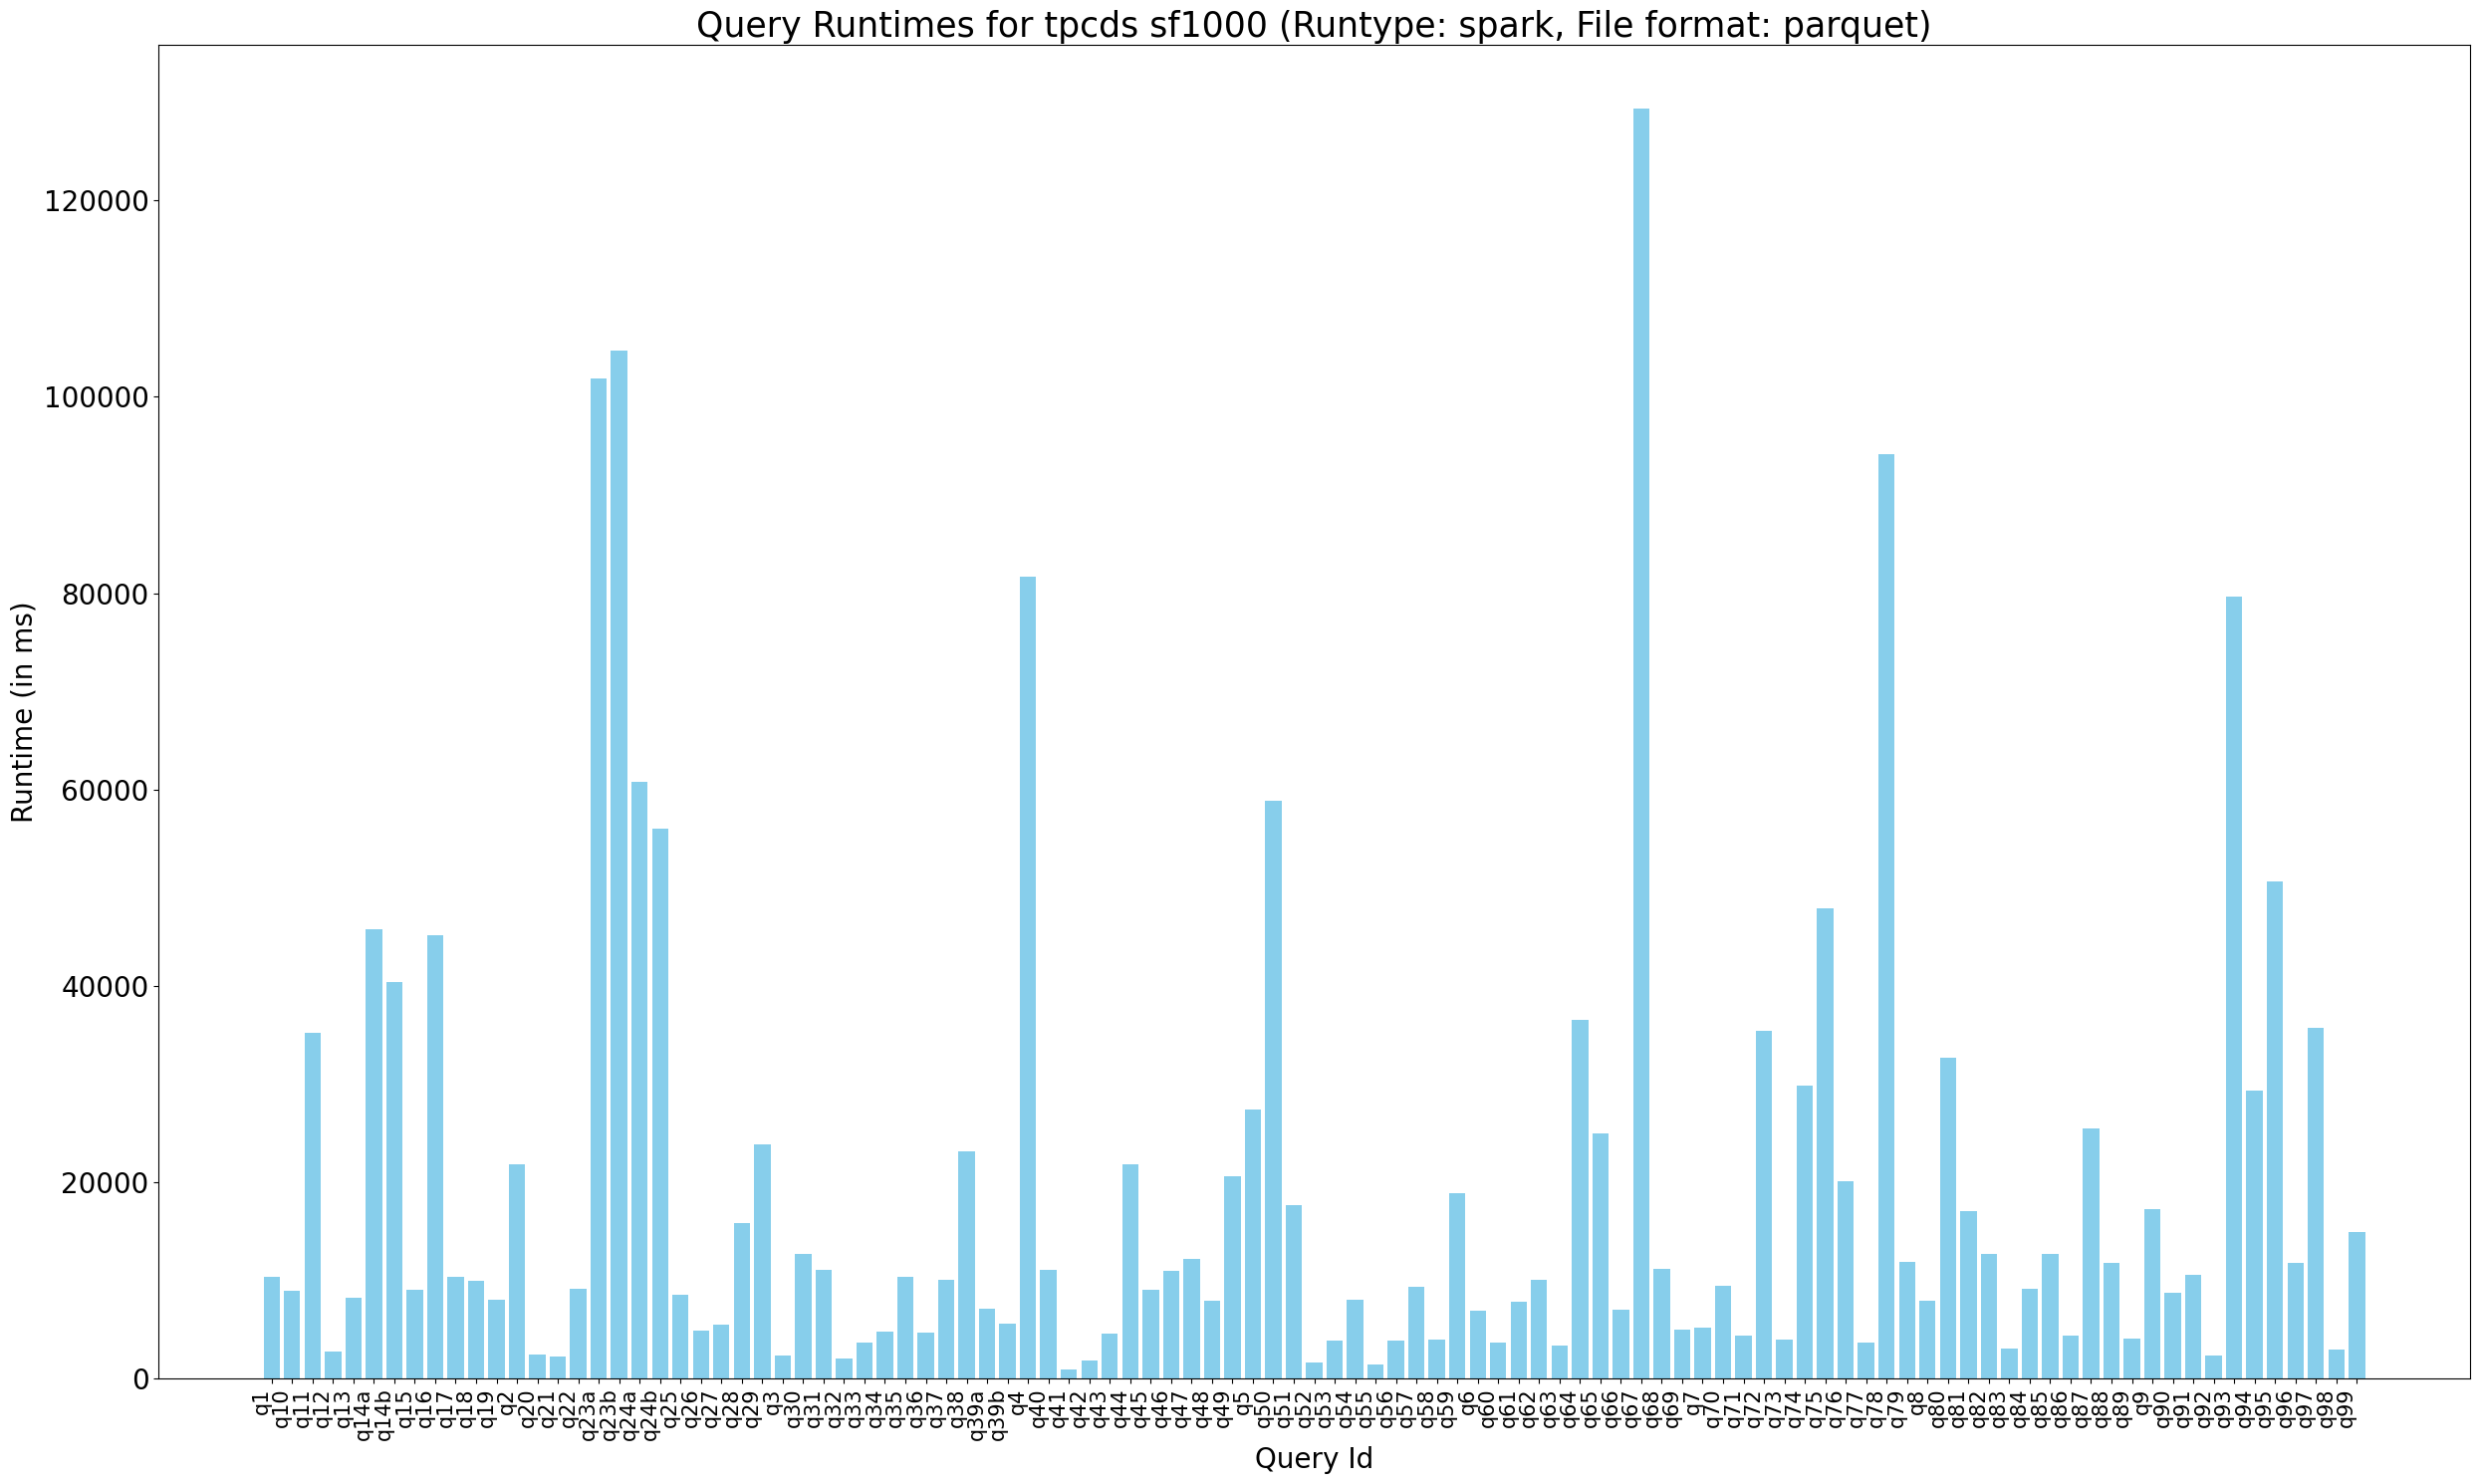

----------------------------------------------------------------------------------------------------------
Writing to GCS bucket sparkpoc-bucket-dpgce-premium-279814974066-us-east1
Runtime results successfully written to gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/spark/output/parquet/tpcds/sf1000/dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv
----------------------------------------------------------------------------------------------------------
Waiting for old YARN application (ID: application_1754464177981_0006) to finish. Current state: FINISHED (0/120s)
Old YARN application (ID: application_1754464177981_0006) has finished with state: FINISHED.


In [ ]:
if second_benchmark is not None:
    # Run second benchmark    
    runTPCBenchmark(spark,second_benchmark,benchmark_configs,BUCKET_NAME,CLUSTER_NAME,RUN_ID,RUNTYPE,TIER)
else:
    print("Second benchmark is empty!")
    print(f"Skipping this step.")    

### DPGCE Premium with Lightning Engine with NQE

#### Defining the Run Id
The following cell defines a unique identifier for the current notebook execution. This Run Id can be used in the `Run_Comparison_Notebook` for Runtime and Cost performance comparison

In [ ]:
RUNTYPE = "native"
RUN_ID = f"dpgce_premium_{RUNTYPE}_{file_format}_{size}_{first_benchmark}"

if second_benchmark is not None:
    RUN_ID+=f"_{second_benchmark}"

from datetime import datetime, timezone
now_utc = datetime.now(timezone.utc)
timestamp_str = now_utc.strftime("%Y-%m-%d_%H-%M-%S")

RUN_ID+=f"_{CLUSTER_NAME}_{REGION}"

RUN_ID+=f"_{timestamp_str}"
print(f"The Run Id for current notebook session is {RUN_ID}")

The Run Id for current notebook session is dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56


#### First Benchmark 

##### Terminate Previous Spark Application
Terminates any active Spark applications currently running.

In [ ]:
# Kill Spark App Launched at Kernel Start
kill_initial_spark_application()

print("----------------------------------------------------------------------------")

# Kill currently running Spark Apps (if any from previous kernel)
kill_previous_spark_application(BUCKET_NAME,CLUSTER_NAME)

----------------------------------------------------------------------------
Attempting to kill previous Spark application: application_1754464177981_0006
Successfully initiated kill for application: application_1754464177981_0006


##### Start Spark Session

In the following step, spark properties are set to run benchmarks.

In [ ]:
#  Start new Spark session with specified configurations
#  tier = premium enables following two properties by default -
#  spark.dataproc.engine=lightningEngine
#  spark.dataproc.lightningEngine.runtime=default

spark_configs = {
    "spark.dataproc.lightningEngine.runtime": "native",
    "spark.dynamicAllocation.enabled": "false",
    "spark.hadoop.fs.gs.grpc.enable": "false"
}

if(size == "sf10000"):
    spark_configs["spark.executor.instances"] = "27"
else:
    spark_configs["spark.executor.instances"] = "10"

spark_builder = SparkSession.builder.appName(f"{first_benchmark} dpgce premium with nqe benchmark run").enableHiveSupport()
# Set the logger to display only ERROR logs
logger = sc._jvm.org.apache.logging.log4j
logger.core.config.Configurator.setAllLevels("org",logger.Level.ERROR)

for key, value in spark_configs.items():
    spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

print(f"Spark Application Name: {spark.sparkContext.appName}")
print(f"Spark Application ID: {spark.sparkContext.applicationId}")
print(f"Spark Session ID: {spark.sparkContext._jsc.sc().applicationId()}")
print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")

# Writing current spark application id to GCS bucket
current_app_id = spark.sparkContext.applicationId
path_to_app_id = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/app_ids/{current_app_id}.txt"
write_app_id_to_gcs(path_to_app_id,current_app_id) 

Spark Application Name: tpch dpgce premium with nqe benchmark run
Spark Application ID: application_1754464177981_0007
Spark Session ID: application_1754464177981_0007
Spark Version: 3.5.3
Spark Master: yarn
Current Spark application ID 'application_1754464177981_0007' written to GCS: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/app_ids/application_1754464177981_0007.txt


##### Run Benchmark
The following cell runs the first benchmark with the configurations passed.

**NOTE - After every benchmark run is complete, it terminates the existing spark session. New spark session is created for each run.**

Running benchmark: tpch, size: sf1000, queries to run: all, runtime engine: native
Setting up TPCH tables


TPCH Tables set up
--------Running TPCH Benchmark with following configurations--------
Queries to run: all
Benchmark: tpch
Result Location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/native/output/parquet/tpch/sf1000/dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56.csv
Scale Factor: sf1000
File Format: parquet
--------------------------------------------------------------------
Running tpch query q1


tpch query q1 ran in 142634 ms
Running tpch query q10


tpch query q10 ran in 56771 ms
Running tpch query q11


tpch query q11 ran in 17166 ms
Running tpch query q12


tpch query q12 ran in 40130 ms
Running tpch query q13


tpch query q13 ran in 62687 ms
Running tpch query q14


tpch query q14 ran in 8775 ms
Running tpch query q15


tpch query q15 ran in 22606 ms
Running tpch query q16


tpch query q16 ran in 25649 ms
Running tpch query q17


tpch query q17 ran in 40085 ms
Running tpch query q18


tpch query q18 ran in 417842 ms
Running tpch query q19


tpch query q19 ran in 28468 ms
Running tpch query q2


tpch query q2 ran in 21952 ms
Running tpch query q20


tpch query q20 ran in 27385 ms
Running tpch query q21


tpch query q21 ran in 228969 ms
Running tpch query q22


tpch query q22 ran in 30912 ms
Running tpch query q3


tpch query q3 ran in 70426 ms
Running tpch query q4


tpch query q4 ran in 58488 ms
Running tpch query q5


tpch query q5 ran in 103344 ms
Running tpch query q6


tpch query q6 ran in 5367 ms
Running tpch query q7


tpch query q7 ran in 39031 ms
Running tpch query q8


tpch query q8 ran in 111141 ms
Running tpch query q9


tpch query q9 ran in 169031 ms
+---------+----------------+
| QueryId | Runtime(in ms) |
+---------+----------------+
|   Sum   |    1728859     |
+---------+----------------+
|    q1   |     142634     |
+---------+----------------+
|   q10   |     56771      |
+---------+----------------+
|   q11   |     17166      |
+---------+----------------+
|   q12   |     40130      |
+---------+----------------+
|   q13   |     62687      |
+---------+----------------+
|   q14   |      8775      |
+---------+----------------+
|   q15   |     22606      |
+---------+----------------+
|   q16   |     25649      |
+---------+----------------+
|   q17   |     40085      |
+---------+----------------+
|   q18   |     417842     |
+---------+----------------+
|   q19   |     28468      |
+---------+----------------+
|    q2   |     21952      |
+---------+----------------+
|   q20   |     27385      |
+---------+----------------+
|   q21   |     228969     |
+---------+----------------+
|   q22   | 

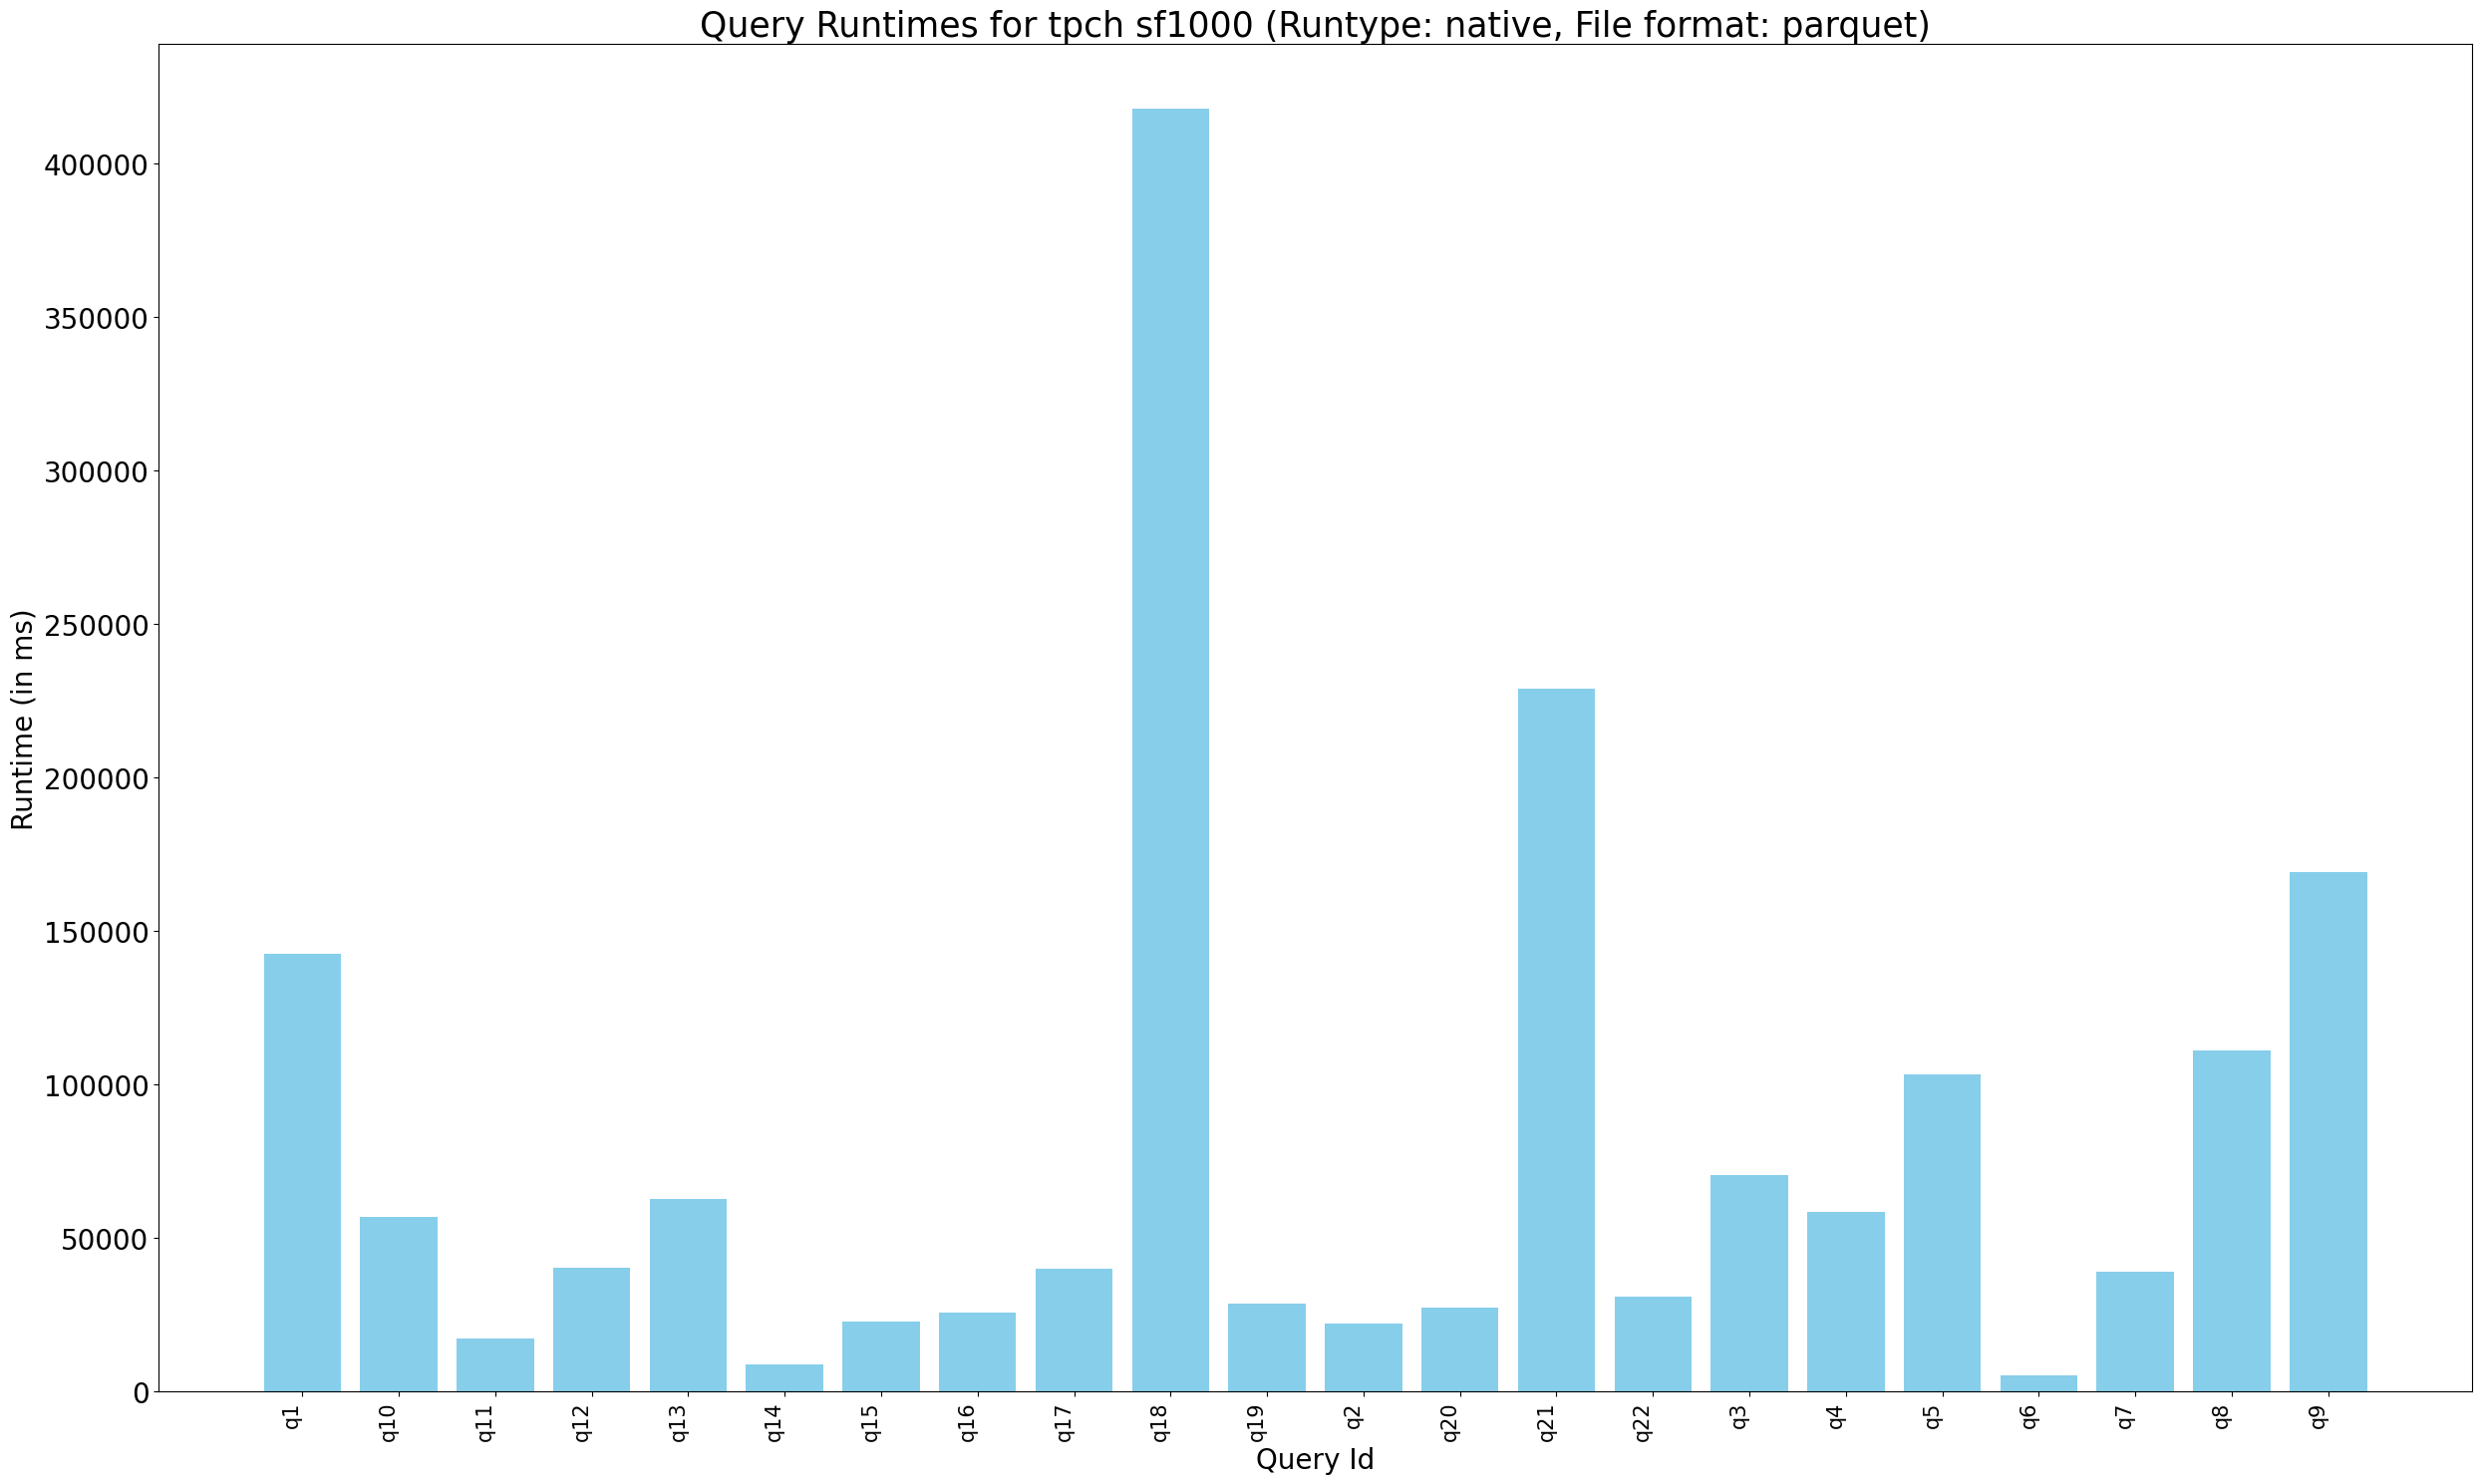

----------------------------------------------------------------------------------------------------------
Writing to GCS bucket sparkpoc-bucket-dpgce-premium-279814974066-us-east1
Runtime results successfully written to gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/native/output/parquet/tpch/sf1000/dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56.csv
----------------------------------------------------------------------------------------------------------
Waiting for old YARN application (ID: application_1754464177981_0007) to finish. Current state: FINISHED (0/120s)
Old YARN application (ID: application_1754464177981_0007) has finished with state: FINISHED.


In [ ]:
# Run first benchmark
runTPCBenchmark(spark,first_benchmark,benchmark_configs,BUCKET_NAME,CLUSTER_NAME,RUN_ID,RUNTYPE,TIER)

#### Second Benchmark

##### Terminate Previous Spark Application
Terminates any active Spark applications currently running.

In [ ]:
if second_benchmark is not None:
    
    # Kill Spark App Launched at Kernel Start
    kill_initial_spark_application()
    
    print("----------------------------------------------------------------------------")
    
    # Kill currently running Spark Apps (if any from previous kernel)
    kill_previous_spark_application(BUCKET_NAME,CLUSTER_NAME)
else:
    print("Second benchmark is empty!")
    print("Skipping this step.")

----------------------------------------------------------------------------
Attempting to kill previous Spark application: application_1754464177981_0007
Successfully initiated kill for application: application_1754464177981_0007


##### Start Spark Session

In the following step, spark properties are set to run benchmarks.

In [ ]:
if second_benchmark is not None:
    
    #  Start new Spark session with specified configurations
    #  tier = premium enables following two properties by default -
    #  spark.dataproc.engine=lightningEngine
    #  spark.dataproc.lightningEngine.runtime=default
    spark_configs = {
        "spark.dataproc.lightningEngine.runtime": "native",
        "spark.dynamicAllocation.enabled": "false",
        "spark.hadoop.fs.gs.grpc.enable": "false"     
    }
    
    if(size == "sf10000"):
        spark_configs["spark.executor.instances"] = "27"
    else:
        spark_configs["spark.executor.instances"] = "10"    

    spark_builder = SparkSession.builder.appName(f"{second_benchmark} dpgce premium with nqe benchmark run").enableHiveSupport()

    # Set the logger to display only ERROR logs
    logger = sc._jvm.org.apache.logging.log4j
    logger.core.config.Configurator.setAllLevels("org",logger.Level.ERROR)

    for key, value in spark_configs.items():
        spark_builder.config(key, value)

    spark = spark_builder.getOrCreate()

    print(f"Spark Application Name: {spark.sparkContext.appName}")
    print(f"Spark Application ID: {spark.sparkContext.applicationId}")
    print(f"Spark Session ID: {spark.sparkContext._jsc.sc().applicationId()}")
    print(f"Spark Version: {spark.version}")
    print(f"Spark Master: {spark.sparkContext.master}")

    # Writing current spark application id to GCS bucket
    current_app_id = spark.sparkContext.applicationId
    path_to_app_id = f"gs://{BUCKET_NAME}/{CLUSTER_NAME}/app_ids/{current_app_id}.txt"
    write_app_id_to_gcs(path_to_app_id,current_app_id)

else:
    print("Second benchmark is empty!")
    print("Skipping this step.")    

Spark Application Name: tpcds dpgce premium with nqe benchmark run
Spark Application ID: application_1754464177981_0008
Spark Session ID: application_1754464177981_0008
Spark Version: 3.5.3
Spark Master: yarn
Current Spark application ID 'application_1754464177981_0008' written to GCS: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/app_ids/application_1754464177981_0008.txt


##### Run Benchmark
The following cell runs the second benchmark with the configurations passed.

**NOTE - After every benchmark run is complete, it terminates the existing spark session. New spark session is created for each run.**

Running benchmark: tpcds, size: sf1000, queries to run: all, runtime engine: native
Setting up TPCDS tables


TPCDS Tables set up
--------Running TPCDS Benchmark with following configurations--------
Queries to run: all
Benchmark: tpcds
Result Location: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/native/output/parquet/tpcds/sf1000/dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56.csv
Scale Factor: sf1000
File Format: parquet
--------------------------------------------------------------------
Running tpcds query q1


tpcds query q1 ran in 9631 ms
Running tpcds query q10


tpcds query q10 ran in 9585 ms
Running tpcds query q11


tpcds query q11 ran in 38210 ms
Running tpcds query q12


tpcds query q12 ran in 2722 ms
Running tpcds query q13


tpcds query q13 ran in 8469 ms
Running tpcds query q14a


tpcds query q14a ran in 45631 ms
Running tpcds query q14b


tpcds query q14b ran in 43341 ms
Running tpcds query q15


tpcds query q15 ran in 8780 ms
Running tpcds query q16


tpcds query q16 ran in 39170 ms
Running tpcds query q17


tpcds query q17 ran in 10314 ms
Running tpcds query q18


tpcds query q18 ran in 9311 ms
Running tpcds query q19


tpcds query q19 ran in 8213 ms
Running tpcds query q2


tpcds query q2 ran in 19796 ms
Running tpcds query q20


tpcds query q20 ran in 2263 ms
Running tpcds query q21


tpcds query q21 ran in 2031 ms
Running tpcds query q22


tpcds query q22 ran in 10240 ms
Running tpcds query q23a


tpcds query q23a ran in 91477 ms
Running tpcds query q23b


tpcds query q23b ran in 95328 ms
Running tpcds query q24a


tpcds query q24a ran in 59297 ms
Running tpcds query q24b


tpcds query q67 ran in 229396 ms
Running tpcds query q68


tpcds query q68 ran in 11528 ms
Running tpcds query q69


tpcds query q69 ran in 5754 ms
Running tpcds query q7


tpcds query q7 ran in 5161 ms
Running tpcds query q70


tpcds query q70 ran in 9513 ms
Running tpcds query q71


tpcds query q71 ran in 4637 ms
Running tpcds query q72


tpcds query q72 ran in 40779 ms
Running tpcds query q73


tpcds query q73 ran in 4942 ms
Running tpcds query q74


tpcds query q74 ran in 32656 ms
Running tpcds query q75


tpcds query q75 ran in 60252 ms
Running tpcds query q76


tpcds query q76 ran in 23544 ms
Running tpcds query q77


tpcds query q77 ran in 3699 ms
Running tpcds query q78


tpcds query q78 ran in 109105 ms
Running tpcds query q79


tpcds query q79 ran in 12143 ms
Running tpcds query q8


tpcds query q8 ran in 8072 ms
Running tpcds query q80


tpcds query q80 ran in 32567 ms
Running tpcds query q81


tpcds query q81 ran in 16859 ms
Running tpcds query q82


tpcds query q82 ran in 13281 ms
Running tpcds query q83


tpcds query q83 ran in 3033 ms
Running tpcds query q84


tpcds query q84 ran in 9239 ms
Running tpcds query q85


tpcds query q85 ran in 13580 ms
Running tpcds query q86


tpcds query q86 ran in 4267 ms
Running tpcds query q87


tpcds query q87 ran in 24690 ms
Running tpcds query q88


tpcds query q88 ran in 10980 ms
Running tpcds query q89


tpcds query q89 ran in 4014 ms
Running tpcds query q9


tpcds query q9 ran in 16659 ms
Running tpcds query q90


tpcds query q90 ran in 7321 ms
Running tpcds query q91


tpcds query q91 ran in 9623 ms
Running tpcds query q92
tpcds query q92 ran in 1870 ms
Running tpcds query q93


tpcds query q93 ran in 78047 ms
Running tpcds query q94


tpcds query q94 ran in 27602 ms
Running tpcds query q95


tpcds query q95 ran in 58444 ms
Running tpcds query q96


tpcds query q96 ran in 11220 ms
Running tpcds query q97


tpcds query q97 ran in 41563 ms
Running tpcds query q98


tpcds query q98 ran in 3543 ms
Running tpcds query q99


tpcds query q99 ran in 15113 ms
+---------+----------------+
| QueryId | Runtime(in ms) |
+---------+----------------+
|   Sum   |    2147987     |
+---------+----------------+
|    q1   |      9631      |
+---------+----------------+
|   q10   |      9585      |
+---------+----------------+
|   q11   |     38210      |
+---------+----------------+
|   q12   |      2722      |
+---------+----------------+
|   q13   |      8469      |
+---------+----------------+
|   q14a  |     45631      |
+---------+----------------+
|   q14b  |     43341      |
+---------+----------------+
|   q15   |      8780      |
+---------+----------------+
|   q16   |     39170      |
+---------+----------------+
|   q17   |     10314      |
+---------+----------------+
|   q18   |      9311      |
+---------+----------------+
|   q19   |      8213      |
+---------+----------------+
|    q2   |     19796      |
+---------+----------------+
|   q20   |      2263      |
+---------+----------------+
|   q21   |

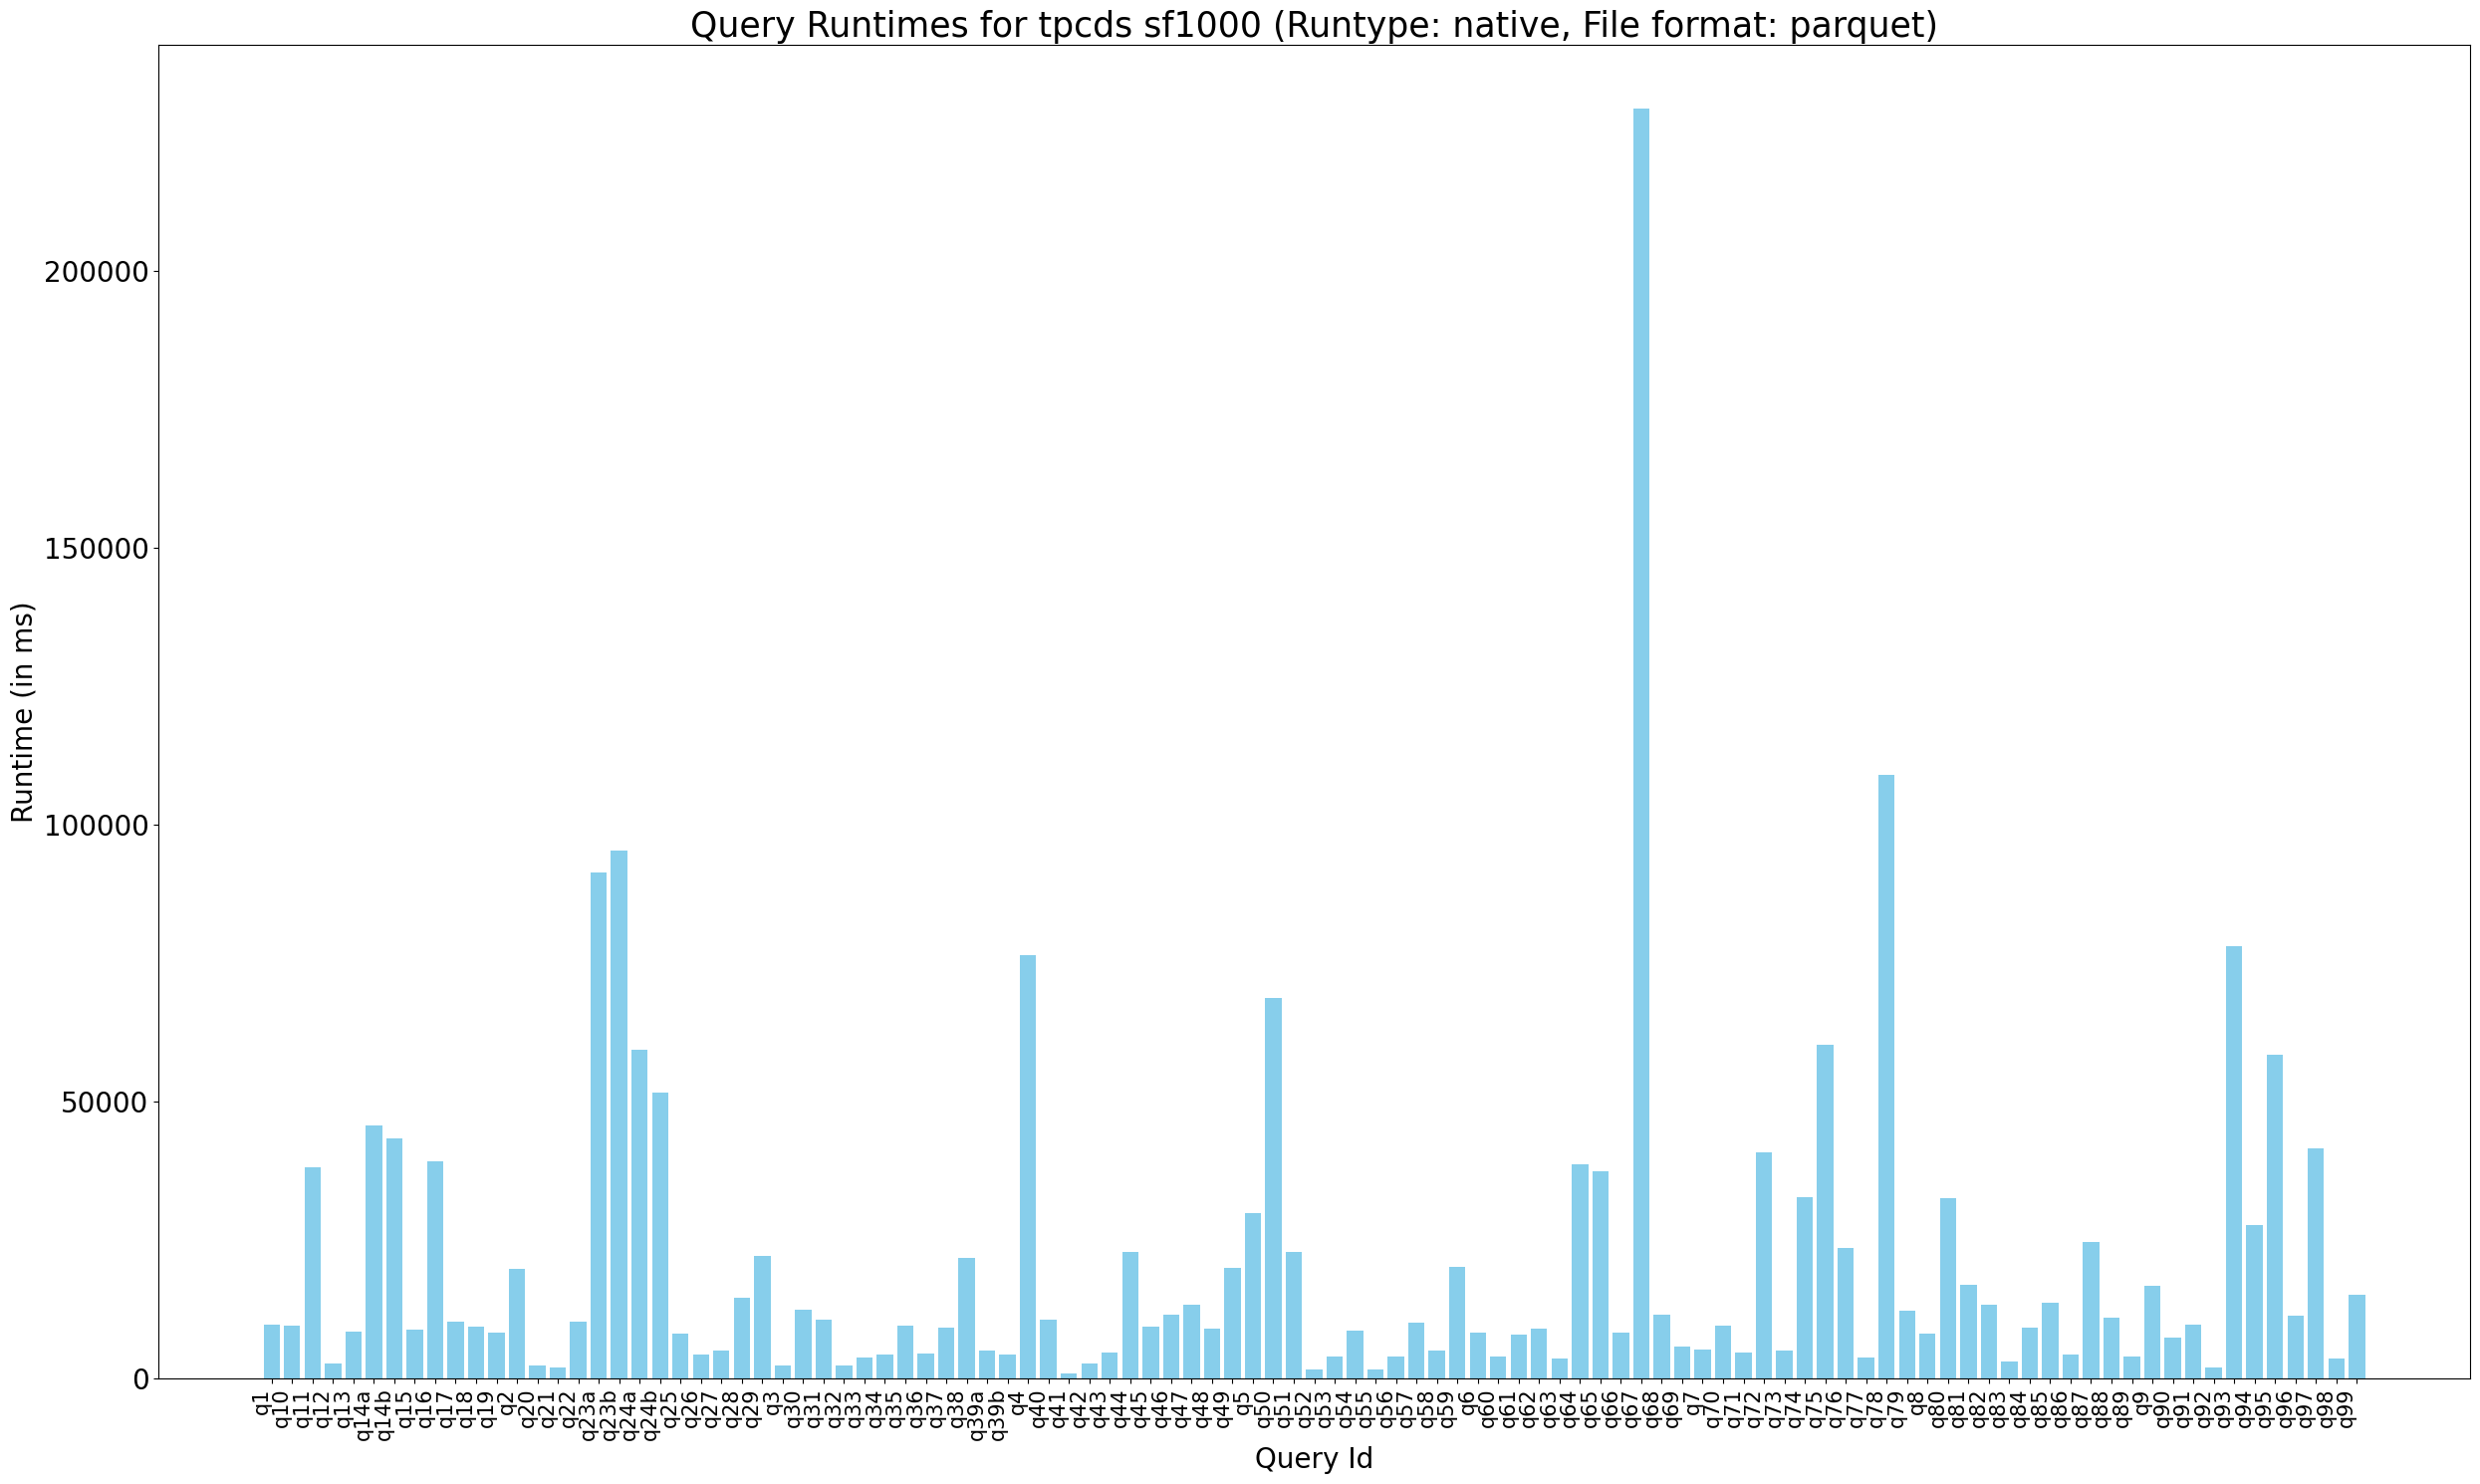

----------------------------------------------------------------------------------------------------------
Writing to GCS bucket sparkpoc-bucket-dpgce-premium-279814974066-us-east1
Runtime results successfully written to gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/native/output/parquet/tpcds/sf1000/dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56.csv
----------------------------------------------------------------------------------------------------------
Waiting for old YARN application (ID: application_1754464177981_0008) to finish. Current state: FINISHED (0/120s)
Old YARN application (ID: application_1754464177981_0008) has finished with state: FINISHED.


In [ ]:
if second_benchmark is not None:
    # Run second benchmark    
    runTPCBenchmark(spark,second_benchmark,benchmark_configs,BUCKET_NAME,CLUSTER_NAME,RUN_ID,RUNTYPE,TIER)
else:
    print("Second benchmark is empty!")
    print(f"Skipping this step.")    